In [12]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

Vamos focar em criar um QA System para eletrônicos

In [13]:
from datasets import load_dataset
subjqa = load_dataset("subjqa", name="electronics")

  0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


Podemos ver que as Answer são armazenadas num campo de texto, enquanto o char de start é provido pelo campo *answer_start*

In [15]:
import pandas as pd
dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}
for split, df in dfs.items():
  print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


Podemos ver que o dataset é relativamente pequeno. Isso é comum dentro do mundo de QA.

In [16]:
qa_cols = ["title", "question", "answers.text",
               "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 stars because it doesn't have a CA...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro battery I bought wouldn't hold a c...


Podemos ver que temos problemas de gramaticais, o que é comum no contexto de FAQ de produto. Também vemos que uma *answers.text* vazia denota uma resposta que não foi possível achar em nenhum review.

In [17]:

start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

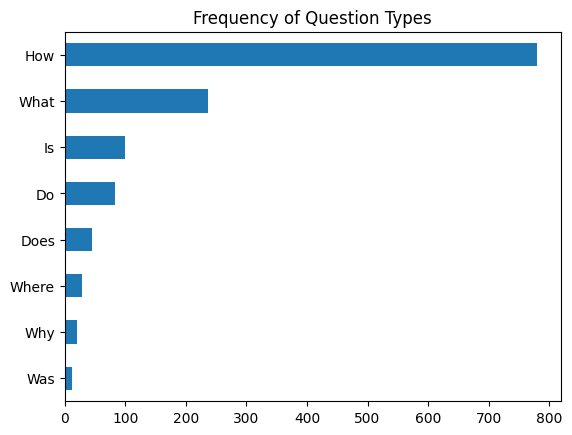

In [19]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]
for q in question_types:
  counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]
pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [20]:
for question_type in ["How", "What", "Is"]:
  for question in (
    dfs["train"][dfs["train"].question.str.startswith(question_type)]
    .sample(n=3, random_state=42)['question']):
    print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


In [21]:
from transformers import AutoTokenizer
model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [22]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \ file size."""
inputs = tokenizer(question, context, return_tensors="pt")

In [23]:
tokenizer.decode(inputs["input_ids"][0])

'[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on \\ file size. [SEP]'

In [24]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.7600, -4.7565, -5.4027, -5.2368, -5.2771, -5.4985, -4.9769, -6.1621,
         -0.7600,  0.6527,  0.0474, -1.4596,  4.0708,  5.2617, -0.7022, -3.8406,
         -1.4190, -4.6270, -1.4310,  3.7721,  4.5929, -0.3631, -3.3237, -5.1965,
         -3.1124, -3.4640, -4.2704, -4.4887, -0.7600]]), end_logits=tensor([[-0.7715, -5.4826, -5.0251, -5.1502, -5.4228, -5.5347, -5.1739, -4.6997,
         -0.7715, -3.6354, -0.5733, -3.6876, -2.8507, -0.8947,  0.6139, -2.4160,
          5.4288,  0.2895, -3.0944, -3.3933,  0.7722,  5.4368, -0.8595, -5.0447,
         -4.4632, -4.1436, -1.1829, -0.3302, -0.7715]]), hidden_states=None, attentions=None)


In [25]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 29])
Start logits shape: torch.Size([1, 29])
End logits shape: torch.Size([1, 29])


In [26]:
import torch
start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 1 mb / minute, so about 6000 hours


In [27]:
from transformers import pipeline
pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)


/Users/petropolis/Library/Python/3.9/lib/python/site-packages/transformers/pipelines/question_answering.py:189: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.23802001774311066,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.23613080382347107,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'},
 {'score': 0.121951162815094, 'start': 38, 'end': 48, 'answer': '6000 hours'}]

In [28]:
pipe(question="Why is there no data?", context=context,
     handle_impossible_answer=True)

{'score': 0.9193896055221558, 'start': 0, 'end': 0, 'answer': ''}

In [29]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"],
                              return_overflowing_tokens=True, max_length=100, stride=25, truncation=True)

In [30]:
for idx, window in enumerate(tokenized_example["input_ids"]):
  print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 88 tokens


In [31]:
for window in tokenized_example["input_ids"]:
  print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and don't feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and don't feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



In [ ]:
from haystack.utils import launch_es

launch_es()

In [51]:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "cf0b22cf2996",
  "cluster_name" : "docker-cluster",
  "cluster_uuid" : "NOsD_AXGRCqhfSdwVRiW8Q",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "docker",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


# Usando o Haystack para criar um Pipeline de QA

Em nosso exemplo de extração de resposta simples, fornecemos a pergunta e o contexto para o modelo.
No entanto, na realidade, os usuários de nosso sistema fornecerão apenas uma pergunta sobre um produto, portanto, precisamos selecionar passagens relevantes entre todas as avaliações em nosso corpus. 
Uma maneira de fazer isso seria concatenar todas as avaliações de um determinado produto e alimentá-las ao modelo como um único e longo contexto. Embora simples, a desvantagem dessa abordagem é que o contexto pode se tornar extremamente longo e, assim, introduzir uma latência inaceitável para as consultas de nossos usuários. 
Por exemplo, vamos supor que, em média, cada produto tenha 30 avaliações e cada avaliação leve 100 milissegundos para ser processada. Se precisarmos processar todas as revisões para obter uma resposta, isso resultará em uma latência média de 3 segundos por consulta do usuário, muito tempo para sites de comércio eletrônico!
Para lidar com isso, os sistemas modernos de controle de qualidade geralmente são baseados na arquitetura *retriever-reader*, que possui dois componentes principais:

**Retriever**
- Responsável por recuperar documentos relevantes para uma determinada consulta. Retrievers são geralmente categorizados como esparsos ou densos. Recuperadores esparsos usam frequências de palavras para representar cada documento e consulta como um vetor esparso.11 A relevância de uma consulta e de um documento é determinada pelo cálculo de um produto interno dos vetores. Por outro lado, os retrievers densos usam codificadores como transformadores para representar a consulta e o documento como embeddings contextualizados (que são vetores densos). Essas incorporações codificam o significado semântico e permitem que os recuperadores densos melhorem a precisão da pesquisa ao entender o conteúdo da consulta.

**Reader**
- Responsável por extrair uma resposta dos documentos fornecidos pelo retriever. O Reader é geralmente um modelo de compreensão de leitura.

<img src="https://raw.githubusercontent.com/nlp-with-transformers/notebooks/884293a3ab50071aa2afd1329ecf4a24f0793333//images/chapter07_retriever-reader.png">

In [36]:
from haystack.document_stores import ElasticsearchDocumentStore

# Return the document embedding for later use with dense retriever 
document_store = ElasticsearchDocumentStore(return_embedding=True)

é sempre uma boa ideia apagar possíveis documentos que já estejam no servidor

In [37]:
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents("document")
    document_store.delete_documents("label")

os campos em "meta" podem ser usados para aplicar filtros nas buscas, então colocamos item_id e question_id para que possamos filtar pelo produto e pela pergunta

In [39]:
for split, df in dfs.items():
    # Exclude duplicate reviews
    docs = [{"content": row["context"], 
             "meta":{"item_id": row["title"], "question_id": row["id"], 
                     "split": split}} 
        for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(docs, index="document")
    
print(f"Loaded {document_store.get_document_count()} documents")

Loaded 1615 documents


# Inicializando um Retriever

In [40]:
from haystack.nodes import BM25Retriever
es_retriever = BM25Retriever(document_store=document_store)

In [64]:
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = es_retriever.retrieve(
    query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})

In [109]:
print(retrieved_docs[0].to_dict())

pd.DataFrame(retrieved_docs[0].to_dict())

{'content': 'This is a gift to myself.  I have been a kindle user for 4 years and this is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my laptop, my phone and my iPod classic.  I love my iPod but watching movies on the plane with it can be challenging because it is so small. Laptops battery life is not as good as the Kindle.  So the Fire combines for me what I needed all three to do. So far so good.', 'content_type': 'text', 'score': 0.6857824513476455, 'meta': {'__pydantic_initialised__': True, 'item_id': 'B0074BW614', 'question_id': '868e311275e26dbafe5af70774a300f3', 'split': 'train'}, 'embedding': None, 'id': '252e83e25d52df7311d597dc89eef9f6', '__pydantic_initialised__': True}


,content,content_type,score,meta,embedding,id,__pydantic_initialised__
__pydantic_initialised__,This is a gift to myself. I have been a kindle user for 4 years and this is...,text,0.685782,True,None,252e83e25d52df7311d597dc89eef9f6,True
item_id,This is a gift to myself. I have been a kindle user for 4 years and this is...,text,0.685782,B0074BW614,None,252e83e25d52df7311d597dc89eef9f6,True
question_id,This is a gift to myself. I have been a kindle user for 4 years and this is...,text,0.685782,868e311275e26dbafe5af70774a300f3,None,252e83e25d52df7311d597dc89eef9f6,True
split,This is a gift to myself. I have been a kindle user for 4 years and this is...,text,0.685782,train,None,252e83e25d52df7311d597dc89eef9f6,True


Além do texto do documento, podemos ver a pontuação que o Elasticsearch calculou por sua relevância para a consulta

In [34]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


# Inicializando um Reader

In [43]:
from haystack.reader.farm import FARMReader
model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride,
                    return_no_answer=True)

In [44]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

{'query': 'How much music can this hold?', 'no_ans_gap': 12.229920625686646, 'answers': [<Answer {'answer': '1 MB/minute, so about 6000 hours', 'type': 'extractive', 'score': 0.48596009612083435, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours depending on \\ file size.', 'offsets_in_document': [{'start': 16, 'end': 48}], 'offsets_in_context': [{'start': 16, 'end': 48}], 'document_id': '697f6abf4828aa51d34e58ddc4b639b4', 'meta': {}}>]}


# Colocando tudo junto

In [45]:
from haystack.pipelines import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(reader, es_retriever)

In [46]:
n_answers = 3
preds = pipe.run(query=query, params={
    "Retriever": {"top_k": 3},
    "Reader": {"top_k": n_answers},
    "filters": {
        "item_id": [item_id],
        "split": ["train"]
    }})
print(f"Question: {preds['query']} \n")

Question: Is it good for reading? 



In [47]:
for idx in range(n_answers):
  print("")
  print(f"Answer {idx+1}: {preds['answers'][idx].answer}")
  print(f"Review snippet: ...{preds['answers'][idx].context}...")
  print("\n\n")


Answer 1: it is great for reading books when no light is available
Review snippet: ...ecoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest good headphones t...




Answer 2: I mainly use it for book reading
Review snippet: ... is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my la...




Answer 3: 
Review snippet: ...None...





# Melhorando nosso Pipe de QA
## Avaliando o Retriever
Avaliar o Retriever é o mesmo que avaliar um `DocumentSearchPipeline`, que consiste em único nó, um Retriever.

In [69]:
from haystack.pipelines import DocumentSearchPipeline

pipe = DocumentSearchPipeline(es_retriever)

In [70]:
from haystack import Label, Answer, Document

labels = []

for i, row in dfs["test"].iterrows():
    # Metadata used for filtering in the Retriever
    meta = {"item_id": row["title"], "question_id": row["id"]}
    # Populate labels for questions with answers
    if len(row["answers.text"]):
        for answer in row["answers.text"]:
            label = Label(
                query=row["question"], answer=Answer(answer=answer), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
                meta=meta, is_correct_answer=True, is_correct_document=True,
                no_answer=False, filters={"item_id": [meta["item_id"]], "split":["test"]})
            labels.append(label)
    # Populate labels for questions without answers
    else:
        label = Label(
            query=row["question"], answer=Answer(answer=""), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
            meta=meta, is_correct_answer=True, is_correct_document=True,
            no_answer=True, filters={"item_id": [row["title"]], "split":["test"]})  
        labels.append(label)

In [72]:
document_store.write_labels(labels, index="label")

In [73]:
print(f"""Loaded {document_store.get_label_count(index="label")} \
question-answer pairs""")

Loaded 910 question-answer pairs


In [74]:
labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"]
)
print(len(labels_agg))

660


In [75]:
# We can run the pipeline with the desired top_k value like this
eval_result = pipe.eval(
    labels=labels_agg,
    params={"Retriever": {"top_k": 3}},
)
metrics = eval_result.calculate_metrics()

In [76]:
print(f"Recall@3: {metrics['Retriever']['recall_single_hit']:.2f}")

Recall@3: 0.93


In [78]:
def evaluate_retriever(retriever, topk_values = [1,3,5,10,20]):
    topk_results = {}
    # Calculate max top_k
    max_top_k = max(topk_values)
    # Create Pipeline
    p = DocumentSearchPipeline(retriever=retriever)
    # Run inference with max top_k by looping over each question-answers pair in test set
    eval_result = p.eval(
        labels=labels_agg,
        params={"Retriever": {"top_k": max_top_k}},
    )
    # Calculate metric for each top_k value
    for topk in topk_values:        
        # Get metrics
        metrics = eval_result.calculate_metrics(simulated_top_k_retriever=topk)
        topk_results[topk] = {"recall": metrics["Retriever"]["recall_single_hit"]}
        
    return pd.DataFrame.from_dict(topk_results, orient="index")


es_retriever_topk_df = evaluate_retriever(es_retriever)

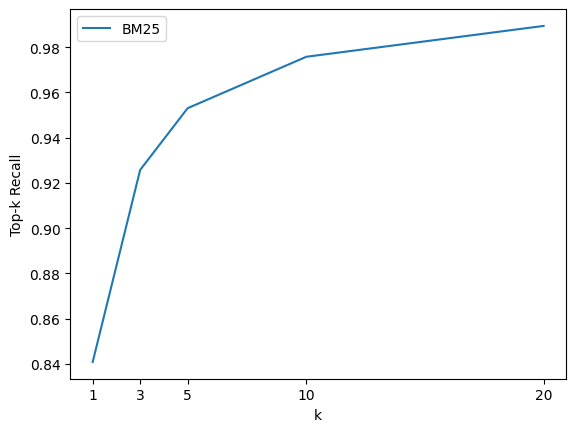

In [79]:
def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y="recall", ax=ax, label=retriever_name)
    plt.xticks(df.index)
    plt.ylabel("Top-k Recall")
    plt.xlabel("k")
    plt.show()
    
plot_retriever_eval([es_retriever_topk_df], ["BM25"])

In [ ]:
from haystack.nodes import DensePassageRetriever

dpr_retriever = DensePassageRetriever(document_store=document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    embed_title=False)

In [81]:
document_store.update_embeddings(retriever=dpr_retriever)

Updating embeddings:   0%|          | 0/1615 [00:00<?, ? Docs/s]

Create embeddings:   0%|          | 0/1616 [00:00<?, ? Docs/s]

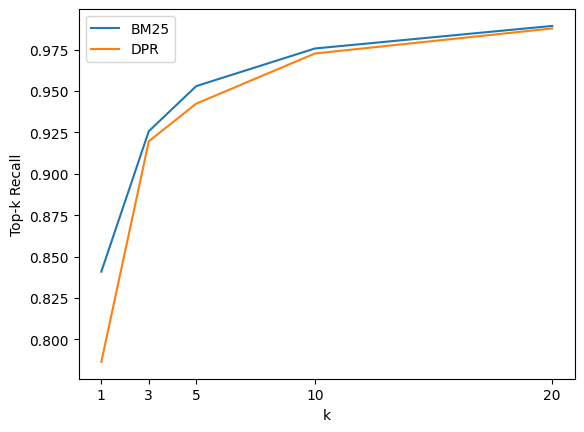

In [82]:
dpr_topk_df = evaluate_retriever(dpr_retriever)
plot_retriever_eval([es_retriever_topk_df, dpr_topk_df], ["BM25", "DPR"])

## Avaliando o Reader

Em QA extrativo há duas formas de ser avaliar o Reader:
- Exact Match (EM): binario, retorna 1 se os caracteres no predito e no "ground truth" são iguais.
- F1 score: média harmonica entre a precisao e o recall

In [83]:
from haystack.modeling.evaluation.squad import compute_f1, compute_exact

pred = "about 6000 hours"
label = "6000 hours"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.8


In [84]:
pred = "about 6000 dollars"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.4


In [85]:
from haystack.pipelines import Pipeline
def evaluate_reader(reader):
    score_keys = ['exact_match', 'f1']
    p = Pipeline()
    p.add_node(component=reader, name="Reader", inputs=["Query"])

    eval_result = p.eval(
        labels=labels_agg,
        documents= [[label.document for label in multilabel.labels] for multilabel in labels_agg],
        params={},
    )
    metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
                
    return {k:v for k,v in metrics["Reader"].items() if k in score_keys}

reader_eval = {}
reader_eval["Fine-tune on SQuAD"] = evaluate_reader(reader)

In the first version no_answer labels weren't taken into account. Because there are quite many of them in the evaluation dataset the numbers differ significantly compared to the first version (EM was at ~0.07 and f1 at ~0.25).

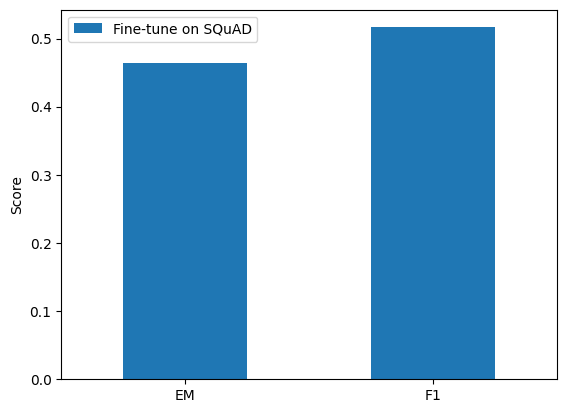

In [86]:
def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval).reindex(["exact_match", "f1"])
    df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
    ax.set_xticklabels(["EM", "F1"])
    plt.legend(loc='upper left')
    plt.show()

plot_reader_eval(reader_eval)

Parece que o modelo ajustado tem um desempenho significativamente pior no SubjQA do que no SQuAD 2.0, onde o MiniLM atinge pontuações EM e F1 de 76,1 e 79,5, respectivamente.

# Adaptacao do dominio (fine tune on squad + subqja)

In [87]:
def create_paragraphs(df):
    paragraphs = []
    id2context = dict(zip(df["review_id"], df["context"]))
    for review_id, review in id2context.items():
        qas = []
        # Filter for all question-answer pairs about a specific context
        review_df = df.query(f"review_id == '{review_id}'")
        id2question = dict(zip(review_df["id"], review_df["question"]))
        # Build up the qas array
        for qid, question in id2question.items():
            # Filter for a single question ID
            question_df = df.query(f"id == '{qid}'").to_dict(orient="list")
            ans_start_idxs = question_df["answers.answer_start"][0].tolist()
            ans_text = question_df["answers.text"][0].tolist()
            # Fill answerable questions
            if len(ans_start_idxs):
                answers = [
                    {"text": text, "answer_start": answer_start}
                    for text, answer_start in zip(ans_text, ans_start_idxs)]
                is_impossible = False
            else:
                answers = []
                is_impossible = True
            # Add question-answer pairs to qas
            qas.append({"question": question, "id": qid, 
                        "is_impossible": is_impossible, "answers": answers})
        # Add context and question-answer pairs to paragraphs
        paragraphs.append({"qas": qas, "context": review})
    return paragraphs
     

In [88]:
product = dfs["train"].query("title == 'B00001P4ZH'")
create_paragraphs(product)

[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones in the past, Pro 4AA and QZ-99.  The Koss Portapro is portable AND has great bass response.  The work great with my Android phone and can be "rolled up" to be carried in my motorcycle jacket or computer bag without getting crunched.  They are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day.  The sound is night and day better than any ear-bud could be and are almost as good as the Pro 4AA.  They are "open air" headphones so you cannot match the bass to the sealed types, but it comes close. For $32, you cannot go wrong.'},
 {'qas': [{'question': 'Is this music song have a goo bass?',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass i

In [89]:
import json

def convert_to_squad(dfs):
    for split, df in dfs.items():
        subjqa_data = {}
        # Create `paragraphs` for each product ID
        groups = (df.groupby("title").apply(create_paragraphs)
            .to_frame(name="paragraphs").reset_index())
        subjqa_data["data"] = groups.to_dict(orient="records")
        # Save the result to disk
        with open(f"electronics-{split}.json", "w+", encoding="utf-8") as f:
            json.dump(subjqa_data, f)
            
convert_to_squad(dfs)

In [90]:
train_filename = "electronics-train.json"
dev_filename = "electronics-validation.json"

reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

Preprocessing Dataset electronics-train.json:  13%|█▎        | 170/1265 [00:18<01:40, 10.91 Dicts/s]WARNING:haystack.modeling.data_handler.processor:Answer 'These earbuds are nothing special. Their best attribute is that they are cheap. The sound from them is nothing special. In comparison to my standard white IPod buds these seem to emphasize the higher frequencies. There seems to be nothing happening in the bass range with these. I don't think they are efficient enough to have much bass at all. To be fair, my IPod buds overly emphasize bass so they are not that accurate either. I also compared these to a pricy Sennheiser set that I've owned for a couple of years and let's just say there is a reason why the Sennheisers cost more.Surely these Panasonic buds are very nice to use if you think they might get damaged somehow in use as it will not break your heart to have to replace them. These might be especially useful if you only listen to talk radio or have high frequency hearing loss. 

In [91]:
reader_eval["Fine-tune on SQuAD + SubjQA"] = evaluate_reader(reader)

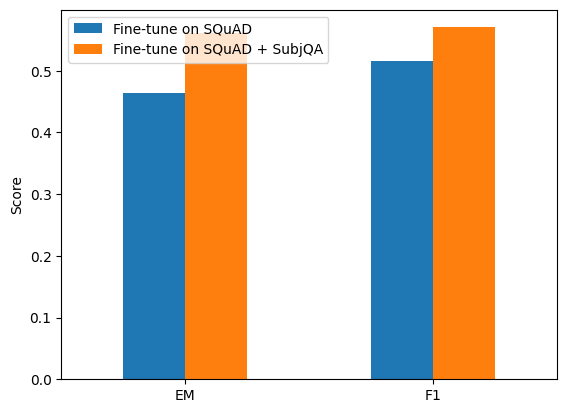

In [92]:
plot_reader_eval(reader_eval)


Podemos ver que a adaptacao do dominio melhorou nosso f1 e EM

In [ ]:
minilm_ckpt = "microsoft/MiniLM-L12-H384-uncased"
minilm_reader = FARMReader(model_name_or_path=minilm_ckpt, progress_bar=False,
                           max_seq_len=max_seq_length, doc_stride=doc_stride,
                           return_no_answer=True)

In [94]:
minilm_reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

Preprocessing Dataset electronics-train.json:  13%|█▎        | 170/1265 [00:14<01:17, 14.09 Dicts/s]WARNING:haystack.modeling.data_handler.processor:Answer 'These earbuds are nothing special. Their best attribute is that they are cheap. The sound from them is nothing special. In comparison to my standard white IPod buds these seem to emphasize the higher frequencies. There seems to be nothing happening in the bass range with these. I don't think they are efficient enough to have much bass at all. To be fair, my IPod buds overly emphasize bass so they are not that accurate either. I also compared these to a pricy Sennheiser set that I've owned for a couple of years and let's just say there is a reason why the Sennheisers cost more.Surely these Panasonic buds are very nice to use if you think they might get damaged somehow in use as it will not break your heart to have to replace them. These might be especially useful if you only listen to talk radio or have high frequency hearing loss. 

In [95]:
reader_eval["Fine-tune on SubjQA"] = evaluate_reader(minilm_reader)

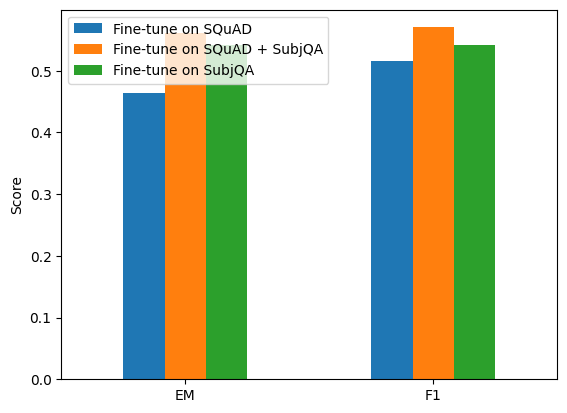

In [96]:
plot_reader_eval(reader_eval)


In [97]:
from haystack.pipelines import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(retriever=es_retriever, reader=reader)

# Evaluate!
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# Extract metrics from reader
reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

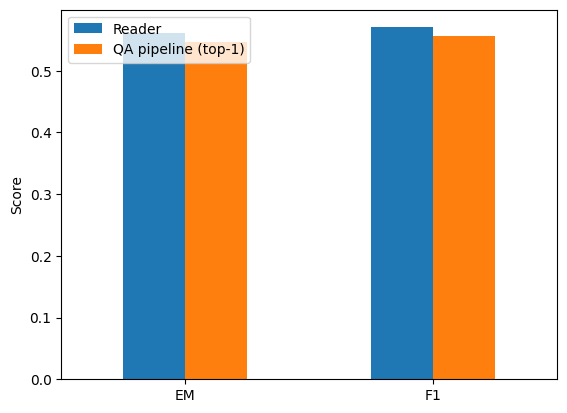

In [106]:
plot_reader_eval({"Reader": reader_eval["Fine-tune on SQuAD + SubjQA"], 
                  "QA pipeline (top-1)": reader_eval["QA Pipeline (top-1)"]})

In [ ]:
from haystack.nodes import RAGenerator

generator = RAGenerator(model_name_or_path="facebook/rag-token-nq",
                        embed_title=False, num_beams=5)

In [102]:
from haystack.pipelines import GenerativeQAPipeline

pipe = GenerativeQAPipeline(generator=generator, retriever=dpr_retriever)

In [103]:
def generate_answers(query, top_k_generator=3):
    preds = pipe.run(query=query, 
                     params={"Retriever": {"top_k":5, 
                                  "filters":{"item_id": ["B0074BW614"]}},
                             "Generator": {"top_k": top_k_generator}})  
    print(f"Question: {preds['query']} \n")
    for idx in range(top_k_generator):
        print(f"Answer {idx+1}: {preds['answers'][idx].answer}")

In [104]:
generate_answers(query)

/Users/petropolis/Library/Python/3.9/lib/python/site-packages/transformers/generation_utils.py:2141: UserWarning: `max_length` is deprecated in this function, use `stopping_criteria=StoppingCriteriaList(MaxLengthCriteria(max_length=max_length))` instead.
  warnings.warn(


Question: Is it good for reading? 

Answer 1:  the screen is absolutely beautiful
Answer 2:  the Screen is absolutely beautiful
Answer 3:  Kindle fire


In [105]:
generate_answers("What is the main drawback?")

Question: What is the main drawback? 

Answer 1:  the price
Answer 2:  no flash support
Answer 3:  the cost
